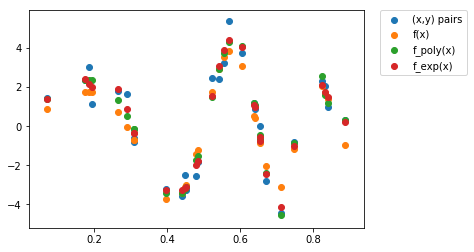

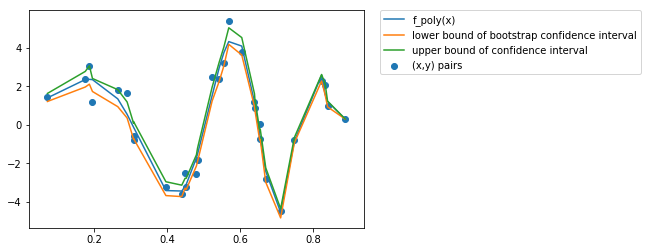

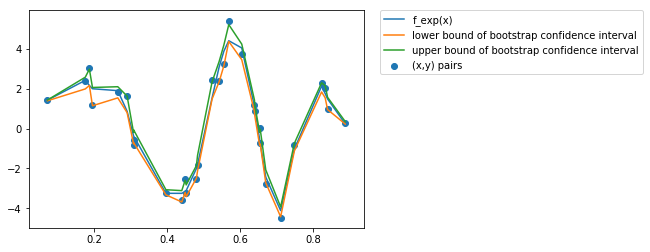

In [6]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import itertools

# generates the input data
def generate_data(n):
    x = np.random.uniform(0,1,size=(n,1))
    eps = np.random.normal(0,1,size=(n,1))
    fX = sincos(x)
    y = fX + eps
    return x,y,fX

# function to generate the input data
def sincos(X):
    fX = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        fX[i][0] = 4*np.sin(np.pi*X[i][0])*np.cos(6*np.pi*X[i][0]*X[i][0])
    return fX

# function that defines the polynomial kernel
def kernel_poly(x,d):
    return (1+np.matmul(x,np.transpose(x)))**d

# function that defines the exponential kernel
def kernel_exp(x,gamma):
    temp = np.matmul(x,np.ones((1,x.shape[0]))) - np.matmul(np.ones((x.shape[0],1)),np.transpose(x))
    return np.exp(-1*gamma*temp**2)

# function that performs the linaer fit by solving for a linaer system
def fit(y,kX,lmd):
    alpha = np.linalg.solve(kX + (lmd * np.identity(kX.shape[0])),y)
    return alpha

# calculates the average square error
def square_error(K,y,alpha):
    err = np.matmul(K,alpha) - y
    return (np.sum(err*err)/len(y))

# given a matrix L, it computes the index (i,j) with the minimum value
def min_index(L):
    minrowindex = []
    minrow = []
    for i in range(len(L)):
        minrowindex.append(np.argmin(np.array(L[i])))
        minrow.append(min(L[i]))
    return (np.argmin(np.array(minrow)),minrowindex[np.argmin(np.array(minrow))])

# generates a bootstrap sample
def bootstrap_sampling(x,y,fX):
    replace = np.random.choice(x.shape[0],x.shape[0],replace = True)
    replace = list(set(replace))
    return x[replace],y[replace], fX[replace], replace

# sorts two lists simultaneously with the first list as the parent list
def sort_two_lists(list1, list2):
    lists = sorted(zip(*[list1,list2]))
    sort1, sort2 = list(zip(*lists))
    return sort1, sort2

# performs leave one out cross validation
# this function must be rewritten using list comprehension
def leave_one_out(x,y):
    lmdrange = (100,0.001)
    drange = (100,1)
    grange = (1000,0.001)
    lmd = lmdrange[0]
    lmdlst = []
    test_errorP = [[]]
    train_errorP = [[]]
    test_errorE = [[]]
    train_errorE = [[]]
    lmd_iter = 0
    while lmd >= lmdrange[1]:
        d = drange[0]
        while d >= drange[1]:
            kXp = kernel_poly(x,d)
            test_error = 0
            train_error = 0
            for i in range(x.shape[0]):
                ind = np.ones((x.shape[0],),bool)
                ind[i] = False
                alphaP = fit(y[ind,:],kXp[ind,:][:,ind],lmd)
                test_error = test_error + square_error(kXp[i,:][ind],y[i,:],alphaP)
                train_error = train_error + square_error(kXp[ind,:][:,ind],y[ind,:],alphaP)
            test_error = test_error/x.shape[0]
            train_error = train_error/x.shape[0]
            test_errorP[lmd_iter].append(test_error)
            train_errorP[lmd_iter].append(train_error)
            d = d - 1
            
        gamma = grange[0]
        while gamma >= grange[1]:
            kXe = kernel_exp(x,gamma)
            test_error = 0
            train_error = 0
            for i in range(x.shape[0]):
                ind = np.ones((x.shape[0],),bool)
                ind[i] = False
                alphaE = fit(y[ind,:],kXe[ind,:][:,ind],lmd)
                test_error = test_error + square_error(kXe[i,:][ind],y[i,:],alphaE)
                train_error = train_error + square_error(kXe[ind,:][:,ind],y[ind,:],alphaE)
            test_error = test_error/x.shape[0]
            train_error = train_error/x.shape[0]
            test_errorE[lmd_iter].append(test_error)
            train_errorE[lmd_iter].append(train_error)
            gamma = gamma/1.1
        
        lmdlst.append(lmd)
        lmd = lmd/1.5
        lmd_iter = lmd_iter + 1
        test_errorP.append([])
        train_errorP.append([])
        test_errorE.append([])
        train_errorE.append([])
    
    d = drange[0]
    dlst = []
    while d>=drange[1]:
        dlst.append(d)
        d = d - 1
    
    gamma = grange[0]
    glst = []
    while gamma>=grange[1]:
        glst.append(gamma)
        gamma = gamma/1.1
    
    return lmdlst,dlst,glst,test_errorP,train_errorP,test_errorE,train_errorE

x,y,fX = generate_data(30)

lmdlst,dlst,glst,test_errorP,train_errorP,test_errorE,train_errorE = leave_one_out(x,y)
# to ensure that the empty list at the end is deleted
del test_errorP[-1]
del test_errorE[-1]
del train_errorP[-1]
del train_errorE[-1]

# computing the parameters that gives the minimum error
(lmdindp,dind) = min_index(test_errorP)
(lmdinde,gind) = min_index(test_errorE)
lmdp = lmdlst[lmdindp]
lmde = lmdlst[lmdinde]
d = dlst[dind]
gamma = glst[gind]

# uncomment to print the chosen parameters
#print(lmdp,d,test_errorP[lmdindp][dind])
#print(lmde,gamma,test_errorE[lmdinde][gind])

#fit all data and plot
kXp = kernel_poly(x,d)
alphaP = fit(y,kXp,lmdp)
Xp_predict = np.matmul(kXp,alphaP)

kXe = kernel_exp(x,gamma)
alphaE = fit(y,kXe,lmde)
Xe_predict = np.matmul(kXe,alphaE)

# plotting the input points with the value of f(x) 
# and the predictions using polynomial kernel and exponential kernel
plt.figure(1)
plt.scatter(np.reshape(x,(-1,)),np.reshape(y,(-1,)),label="(x,y) pairs")
plt.scatter(np.reshape(x,(-1,)),np.reshape(fX,(-1,)),label="f(x)")
plt.scatter(np.reshape(x,(-1,)),np.reshape(Xp_predict,(-1,)),label="f_poly(x)")
plt.scatter(np.reshape(x,(-1,)),np.reshape(Xe_predict,(-1,)),label="f_exp(x)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();


xplt, Xpplt = sort_two_lists(np.reshape(x,(-1,)),np.reshape(Xp_predict,(-1,)))
xplt, Xeplt = sort_two_lists(np.reshape(x,(-1,)),np.reshape(Xe_predict,(-1,)))


#Bootstrapping
P_bootstrap = [[] for i in range(30)]
E_bootstrap = [[] for i in range(30)]

for i in range(300):
    boot_x, boot_y, boot_fX, ind = bootstrap_sampling(x,y,fX)
    
    kXp = kernel_poly(boot_x,d)
    alphaP = fit(boot_y,kXp,lmdp)
    Xp_predict = np.matmul(kXp,alphaP)
    for j in range(len(ind)):
        P_bootstrap[ind[j]].append(Xp_predict[j])

    kXe = kernel_exp(boot_x,gamma)
    alphaE = fit(boot_y,kXe,lmde)
    Xe_predict = np.matmul(kXe,alphaE)
    for j in range(len(ind)):
        E_bootstrap[ind[j]].append(Xe_predict[j])

for i in range(30):
    P_bootstrap[i].sort()
    E_bootstrap[i].sort()

lowerP = [P_bootstrap[i][7] for i in range(30)]
upperP = [P_bootstrap[i][-7] for i in range(30)]
lowerE = [E_bootstrap[i][7] for i in range(30)]
upperE = [E_bootstrap[i][-7] for i in range(30)]

xplt, lowerP = sort_two_lists(np.reshape(x,(-1,)),lowerP)
xplt, upperP = sort_two_lists(np.reshape(x,(-1,)),upperP)
xplt, lowerE = sort_two_lists(np.reshape(x,(-1,)),lowerE)
xplt, upperE = sort_two_lists(np.reshape(x,(-1,)),upperE)

# plot with bootstrap confidence intervals for polynomial kernel
plt.figure(2)
plt.scatter(np.reshape(x,(-1,)),np.reshape(y,(-1,)),label="(x,y) pairs")
plt.plot(xplt,Xpplt,label="f_poly(x)")
plt.plot(xplt,lowerP,label="lower bound of bootstrap confidence interval")
plt.plot(xplt,upperP,label="upper bound of confidence interval")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();

# plot with bootstrap confidence intervals for exponential kernel
plt.figure(3)
plt.scatter(np.reshape(x,(-1,)),np.reshape(y,(-1,)),label="(x,y) pairs")
plt.plot(xplt,Xeplt,label="f_exp(x)")
plt.plot(xplt,lowerE,label="lower bound of bootstrap confidence interval")
plt.plot(xplt,upperE,label="upper bound of bootstrap confidence interval")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();

In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import itertools

A = [[]]
A[0].append(1)
A.append([])
A[1].append(2)
A[1].append(3)
A[0].append(-1)
print(A)
B = np.reshape(A,(2,2))
print(np.min(B))
print(np.argmin(B))

[[1, -1], [2, 3]]
-1
1


In [ ]:
A = [[1,2], [4,5], [-1,0]]
print(A)
print(min_index(A))

In [ ]:
print((1+2)**4)
print(np.exp(-1*1*(2-4)**2))

In [16]:
A = np.ones((10,1))
B = np.ones((10,10))
print(np.matmul(B[1,:],A))
print(A - [1,2])

[10.]
[[ 0. -1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -1.]]


In [14]:
x,y,fx = generate_data(20)
kX = kernel_poly(x,100)
ind = np.ones((kX.shape[0],),bool)
ind[0] = False
print(ind)
#print(kX[ind,:][:,ind].shape)
print(kX)
#print(kX[ind,:][:,ind])

print(kX[0,:][ind])
alpha = np.linalg.solve(kX+100*np.identity(kX.shape[0]),y)
print(y)

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[[3.25187074e+11 2.41555783e+05 8.66634992e+11 6.24772582e+17
  3.05094520e+16 2.54154946e+12 1.83486121e+18 9.28852358e+06
  1.73434510e+12 7.76303863e+05 1.32171727e+18 4.21779391e+04
  3.45795023e+17 2.93073401e+18 4.42422263e+18 6.46735282e+10
  1.91290887e+03 1.79869489e+07 1.06869397e+15 2.74044032e+11]
 [2.41555783e+05 2.64604345e+02 3.95058671e+05 4.38883925e+08
  8.77915550e+07 6.79772717e+05 7.83623710e+08 1.47041612e+03
  5.60405936e+05 4.56355302e+02 6.56625019e+08 1.17894229e+02
  3.19630316e+08 1.00908860e+09 1.26098430e+09 1.07965107e+05
  2.86584545e+01 2.01309160e+03 1.51078252e+07 2.21732600e+05]
 [8.66634992e+11 3.95058671e+05 2.38314583e+12 2.56460573e+18
  1.15042342e+17 7.23095418e+12 7.75862567e+18 1.73552288e+07
  4.87529405e+12 1.32561419e+06 5.53875971e+18 6.46080648e+04
  1.39631293e+18 1.25520157e+19 1.91618702e+19 1.63568661e+11
  2.601

In [10]:
import numpy as np

a = np.ones(2)
a[1] = 2

ind = [1,1]
print(a[ind])
replace = np.random.choice(5,5,replace = True)
print(replace)
print(type(replace))
print(list(set(replace)))
b = np.ones(10)
print(b[list(set(replace))])

[2. 2.]
[2 3 4 1 1]
<class 'numpy.ndarray'>
[1, 2, 3, 4]
[1. 1. 1. 1.]


In [5]:
import numpy as np

a = np.ones(5)
a[-1] = 8
print(a)

[1. 1. 1. 1. 8.]
